### Introduccion

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import accuracy_score
from pmdarima.arima import auto_arima
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from neuralprophet import NeuralProphet
from tensorflow.keras.layers import Reshape
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import datetime
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from sklearn.model_selection import GridSearchCV
from sklearn.base import RegressorMixin

In [7]:
# Cargar el dataset
dataset = pd.read_csv('/Users/mmarchetta/Desktop/Tesis-2024/data-visualization/final_dataset.csv')
validation = pd.read_csv('/Users/mmarchetta/Desktop/Tesis-2024/models/validation.csv')

# dataset.drop(['Open_time'], axis=1, inplace=True)
dataset['Open_time'] = pd.to_datetime(dataset['Open_time'])

dataset.drop(['Sentimiento'], axis=1, inplace=True)
dataset.drop(['Sentimiento_coin'], axis=1, inplace=True)
dataset.drop(['Sentimiento_referentes'], axis=1, inplace=True)

# Limitar los valores float a 2 decimales en todo el dataframe
dataset = dataset.round(2)

### Sarimax

In [3]:
exog_vars = [col for col in dataset.columns if col not in ['Tendencia']]

# Convertir todas las variables exógenas a tipo numérico
dataset[exog_vars] = dataset[exog_vars].apply(pd.to_numeric, errors='coerce')

# Dividir los datos en entrenamiento y prueba
train_size = int(len(dataset) * 0.8)
train, test = dataset.iloc[:train_size], dataset.iloc[train_size:]

# Convertir los datos de entrenamiento a arrays de numpy
label_encoder = LabelEncoder()
train_endog_encoded = label_encoder.fit_transform(train['Tendencia'])
train_exog = train[exog_vars].values

# Entrenar el modelo ARIMAX
model = auto_arima(train_endog_encoded, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True, cv=10, information_criterion='aic')

display(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.59 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2124.374, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1936.089, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2122.374, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1934.941, Time=0.08 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1936.057, Time=0.25 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1935.470, Time=0.69 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=1863.896, Time=0.09 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=1865.379, Time=0.25 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=1865.360, Time=0.28 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=1864.240, Time=1.06 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=1816.482, Time=0.11 sec
 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=1817.194, Time=0.30 sec
 ARIMA(3,1,0)(0,0,1)[12] inte

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  696
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -828.836
Date:                Tue, 19 Mar 2024   AIC                           1661.672
Time:                        13:58:50   BIC                           1670.760
Sample:                             0   HQIC                          1665.186
                                - 696                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9784      0.009   -114.456      0.000      -0.995      -0.962
sigma2         0.6330      0.061     10.387      0.000       0.514       0.752
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                52.88
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                            -0.03
Prob(H) (two-sided):                  0.15   Kurtosis:                         1.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [4]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  696
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -828.836
Date:                Tue, 19 Mar 2024   AIC                           1661.672
Time:                        13:59:02   BIC                           1670.760
Sample:                             0   HQIC                          1665.186
                                - 696                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9784      0.009   -114.456      0.000      -0.995      -0.962
sigma2         0.6330      0.061     10.387      0.000       0.514       0.752
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [6]:
# Hacer predicciones pasando la fecha de inicio y la fecha final
forecast = model.predict(n_periods=16)

# Mostrar las predicciones
print("Predicciones para los próximos 16 días:")
print(forecast)


Predicciones para los próximos 16 días:
[1.33541458 1.33541458 1.33541458 1.33541458 1.33541458 1.33541458
 1.33541458 1.33541458 1.33541458 1.33541458 1.33541458 1.33541458
 1.33541458 1.33541458 1.33541458 1.33541458]


In [7]:
def categorizar_tendencia(cambio):
    if cambio > 0.015:
        return 'Alcista'
    elif -0.015 <= cambio <= 0.015:
        return 'Lateral'
    elif cambio <= -0.015:
        return 'Bajista'

In [8]:
forecast_series = pd.Series(forecast)

# Categorizar la tendencia del primer registro de pronóstico
tendencia_primer_registro = categorizar_tendencia((forecast_series.iloc[-1] - test['Close'].iloc[-2]) / test['Close'].iloc[-2])

# Calcular el cambio porcentual en el precio de cierre entre periodos consecutivos en el pronóstico
cambios_percentuales_forecast = forecast_series.pct_change()

# Aplicar la función categorizar_tendencia a los cambios porcentuales en el pronóstico
tendencias_forecast = cambios_percentuales_forecast.apply(categorizar_tendencia)

# Actualizar la categoría de la tendencia del primer registro de pronóstico
tendencias_forecast.iloc[0] = tendencia_primer_registro

# Mostrar los resultados
print(tendencias_forecast)

0     Bajista
1     Lateral
2     Lateral
3     Lateral
4     Lateral
5     Lateral
6     Lateral
7     Lateral
8     Lateral
9     Lateral
10    Lateral
11    Lateral
12    Lateral
13    Lateral
14    Lateral
15    Lateral
dtype: object


### VAR

In [9]:
# Leo el dataset de nuevo para evitar cualquier error dejado en el dataset anterior
var_dataset = pd.read_csv('/Users/mmarchetta/Desktop/Tesis-2024/data-visualization/final_dataset.csv')

var_dataset.drop(['Sentimiento'], axis=1, inplace=True)
var_dataset.drop(['Sentimiento_coin'], axis=1, inplace=True)
var_dataset.drop(['Sentimiento_referentes'], axis=1, inplace=True)

# Convierto los valores flotantes a un maximo de 2 decimales
var_dataset = var_dataset.round(2)

In [10]:
X = var_dataset.drop(columns=["Tendencia", "Open_time"])

model = VAR(X)
model_fitted = model.fit()

forecast = model_fitted.forecast(model_fitted.endog, steps=16)
forecast_rounded = forecast.round(2)

forecast_rounded = []
for arr in forecast:
    arr_rounded = [round(x, 2) for x in arr]
    forecast_rounded.append(arr_rounded)
    
forecast_df = pd.DataFrame(forecast_rounded, columns=X.columns)

# Mostrar el DataFrame resultante
display(forecast_df)

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Open_BTCUSDT,High_BTCUSDT,Low_BTCUSDT,...,Compound total coin,Tweets_Utilizados_referentes,Cantidad_pos_referentes,Cantidad_neg_referentes,Cantidad_neu_referentes,Compound total referentes,Tweets_Utilizados_whale_alert,Buy_1000x_high,sell_1000x_high,total_trades_binance
0,7.65,7.77,7.34,7.60,7414034.84,53053660.37,128696.87,51794.90,52998.65,50635.68,...,43.47,0.52,0.06,0.16,0.14,0.05,44.46,439.86,401.70,87309.76
1,7.60,7.97,7.30,7.69,7968356.95,68042550.01,183812.50,51999.70,53035.91,50858.76,...,45.09,0.67,0.11,0.11,0.17,0.21,37.45,431.50,373.27,125999.62
2,7.69,8.03,7.40,7.75,8035727.27,71710688.75,186866.25,51986.91,53006.28,50919.78,...,44.65,0.52,0.08,0.06,0.14,0.16,33.70,414.39,348.47,125524.37
3,7.75,8.04,7.43,7.77,7889697.52,69839145.71,180578.21,52014.78,53008.52,50954.22,...,43.90,0.46,0.07,0.02,0.14,0.16,31.75,393.52,324.51,120798.98
4,7.77,8.05,7.46,7.78,7720049.72,67536079.60,175298.92,52046.56,53006.89,51005.11,...,43.12,0.36,0.06,-0.03,0.12,0.15,30.15,374.87,305.39,117374.19
5,7.78,8.04,7.46,7.76,7586497.55,65490169.64,170421.59,52069.84,53008.70,51038.55,...,42.31,0.26,0.06,-0.06,0.10,0.14,28.89,359.81,289.37,113803.56
6,7.76,8.03,7.45,7.75,7498764.35,63999529.45,167397.23,52082.26,53008.91,51057.88,...,41.53,0.15,0.05,-0.09,0.07,0.12,27.91,347.74,276.66,111220.00
7,7.75,8.01,7.43,7.73,7442275.75,62826459.76,165461.87,52087.69,53009.63,51070.48,...,40.80,0.06,0.04,-0.11,0.05,0.10,27.13,337.95,266.34,109070.80
8,7.73,7.99,7.42,7.72,7401377.49,61847775.74,164213.08,52091.28,53014.83,51082.22,...,40.16,-0.03,0.03,-0.12,0.03,0.08,26.51,329.56,257.68,107305.60
9,7.72,7.98,7.42,7.71,7362918.25,60976907.36,163331.06,52098.80,53027.65,51098.89,...,39.61,-0.11,0.02,-0.13,0.01,0.06,25.99,321.93,250.07,105864.23


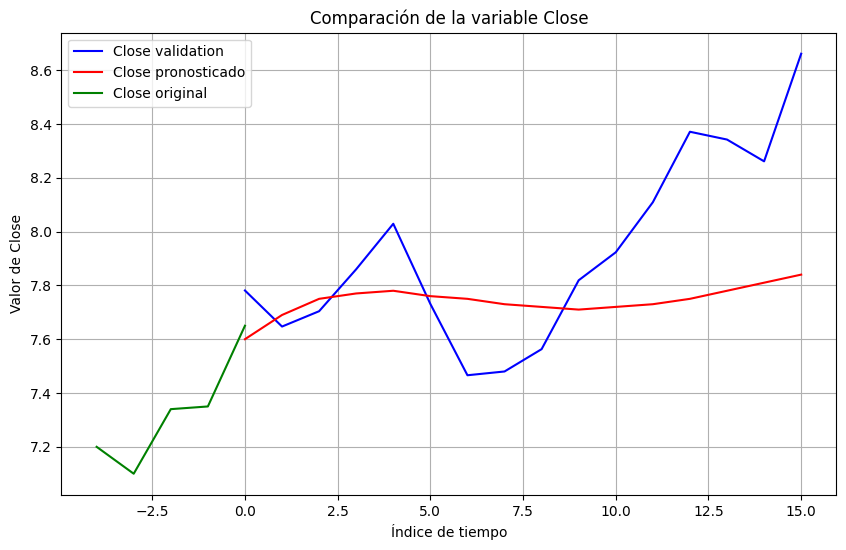

In [221]:
last_five_X_records = X.tail(5)
last_five_X_records.index = range(-4, 1)

plt.figure(figsize=(10, 6))
plt.plot(validation['Close'], label='Close validation', color='blue')
plt.plot(forecast_df['Close'], label='Close pronosticado', color='red')
plt.plot(last_five_X_records['Close'], label='Close original', color='green')
plt.title('Comparación de la variable Close')
plt.xlabel('Índice de tiempo')
plt.ylabel('Valor de Close')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Categorizo las diferencias. Tener en cuenta qeu el registro 0 hay que ignorarlo, porque se calcula a partir de X, no sobre validacion
forecast_series_var = forecast_df['Close']
tendencia_primer_registro_var = categorizar_tendencia(forecast_series_var.iloc[0] - X['Close'].iloc[-1])
cambios_forecast_var = forecast_series_var.diff()
tendencias_forecast_var = cambios_forecast_var.apply(categorizar_tendencia)
tendencias_forecast_var.iloc[0] = tendencia_primer_registro_var
print(tendencias_forecast_var)

0     Bajista
1     Alcista
2     Alcista
3     Alcista
4     Lateral
5     Bajista
6     Lateral
7     Bajista
8     Lateral
9     Lateral
10    Lateral
11    Lateral
12    Alcista
13    Alcista
14    Alcista
15    Alcista
Name: Close, dtype: object


### Facebook Prophet

In [8]:
fb_prophett_dataset = pd.read_csv('/Users/mmarchetta/Desktop/Tesis-2024/data-visualization/final_dataset.csv')
fb_prophett_dataset.drop(['Sentimiento', 'Sentimiento_coin', 'Sentimiento_referentes'], axis=1, inplace=True)
fb_prophett_dataset.fillna(0, inplace=True)

columnas = []
# "Open", "High", "Low", "Volume", "Quote asset volume", 
#             "Number of trades", "Open_BTCUSDT", "High_BTCUSDT", "Low_BTCUSDT", 
#             "Close_BTCUSDT", "Volume_BTCUSDT",
#             "Number_of_trades_BTCUSDT", "Open_ETHUSDT", "High_ETHUSDT", "Low_ETHUSDT", 
#             "Close_ETHUSDT", "Volume_ETHUSDT", 
#             "Number_of_trades_ETHUSDT", "Open_BNBUSDT", "High_BNBUSDT", "Low_BNBUSDT", 
#             "Close_BNBUSDT", "Volume_BNBUSDT",
#             "Number_of_trades_BNBUSDT", "SMA_20", "EMA_20", "Upper_Band", 
#             "Middle_Band", "Lower_Band", "RSI", "MACD", "Signal", "ADX", 
#             "SlowK", "SlowD", "CCI", "ATR", "MFI", "buy_1000x_high_coinbase", 
#             "sell_1000x_high_coinbase", "total_trades_coinbase","Tweets_Utilizados",
#             "Tweets_Utilizados_referentes", "Tweets_Utilizados_coin", "Cantidad_neg",
#             "Cantidad_neu", "Compound total", "Cantidad_pos_coin", "Cantidad_neg_coin",
#             "Cantidad_neu_coin", "Compound total coin", "Cantidad_neu_referentes", 
#             "Compound total referentes", "Tweets_Utilizados_whale_alert", 
#             "Buy_1000x_high", "sell_1000x_high", "total_trades_binance",
#             "Cantidad_pos", "Cantidad_pos_referentes", "Cantidad_neg_referentes"]

fb_prophett_dataset = fb_prophett_dataset.round(2)

fb_prophett_dataset["ds"] = pd.to_datetime(fb_prophett_dataset["Open_time"])
fb_prophett_dataset.drop(columns=["Tendencia", "Open_time"], axis=1, inplace=True)
fb_prophett_dataset_normalized = fb_prophett_dataset

for col in columnas:
    scaler = MinMaxScaler()
    fb_prophett_dataset_normalized[col] = scaler.fit_transform(fb_prophett_dataset[[col]])

fb_prophett_dataset_normalized = pd.DataFrame(fb_prophett_dataset_normalized, columns=columnas)
fb_prophett_dataset_normalized["ds"] = fb_prophett_dataset["ds"]

scaler = MinMaxScaler()
fb_prophett_dataset_normalized["y"] = scaler.fit_transform(fb_prophett_dataset[["Close"]])

# fb_prophett_dataset_normalized.rename(columns={'Close': 'y'}, inplace=True)
# columnas.remove("Close")

fb_prophett_model = Prophet()

for columna in columnas:
    fb_prophett_model.add_regressor(columna)

fb_prophett_model.fit(fb_prophett_dataset_normalized)

16:40:37 - cmdstanpy - INFO - Chain [1] start processing
16:40:37 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
future = fb_prophett_model.make_future_dataframe(periods=15, include_history=True)

for columna in columnas:
    future[columna] = fb_prophett_dataset_normalized[columna]

future.fillna(0, inplace=True)

# print(future.tail(7))
forecast = fb_prophett_model.predict(future)

In [10]:

forecast['yhat_inverse'] = scaler.inverse_transform(forecast[['yhat']])

# Imprimir las predicciones
print(forecast['yhat_inverse'].tail(17))

869    7.292632
870    7.348347
871    7.296441
872    7.281426
873    7.351048
874    7.348532
875    7.198321
876    7.181988
877    7.163628
878    7.048715
879    6.983695
880    7.017911
881    6.995811
882    6.842656
883    6.840421
884    6.853169
885    6.785926
Name: yhat_inverse, dtype: float64


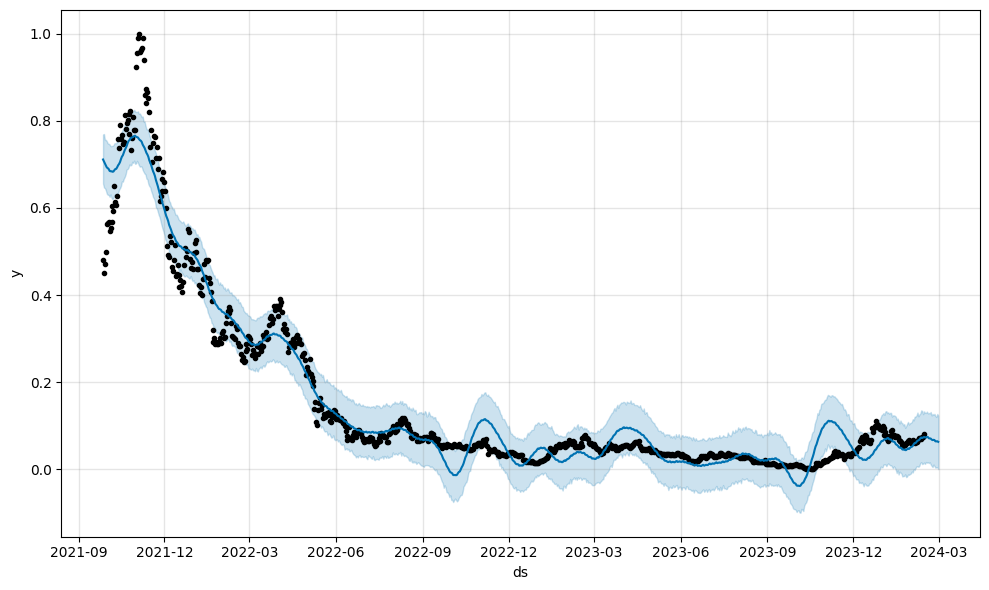

In [11]:
fig1 = fb_prophett_model.plot(forecast)

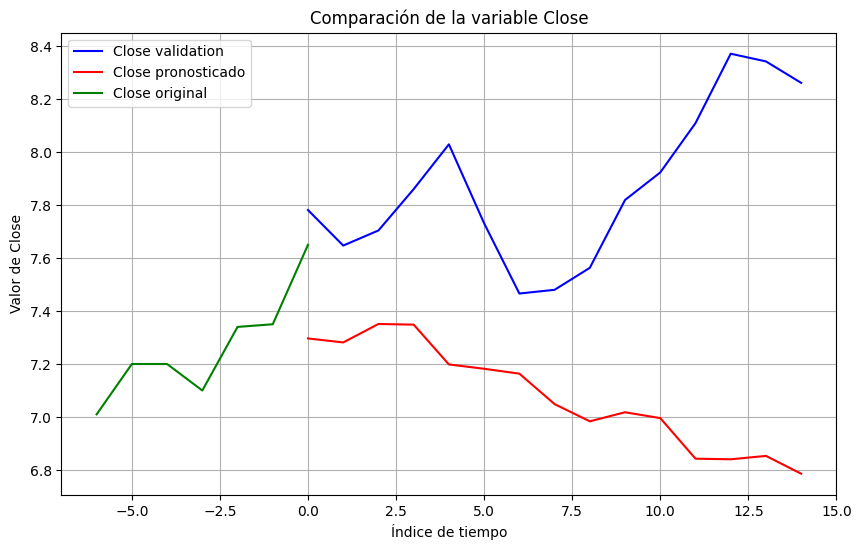

In [310]:
last_five_X_records = fb_prophett_dataset.tail(7)
last_five_X_records.index = range(-6, 1)

last_X_forecasts = forecast['yhat_inverse'].tail(15)
last_X_forecasts.index = range(0, 15)

plt.figure(figsize=(10, 6))
plt.plot(validation['Close'].head(15), label='Close validation', color='blue')
plt.plot(last_X_forecasts, label='Close pronosticado', color='red')
plt.plot(last_five_X_records['Close'], label='Close original', color='green')
plt.title('Comparación de la variable Close')
plt.xlabel('Índice de tiempo')
plt.ylabel('Valor de Close')
plt.legend()
plt.grid(True)
plt.show()

Parece que el modelo pierde performance al agregar variables externas a la serie. La performance del model, sin estas varaibles, tampoco es destable. La libreria no provee muchas formas de optimizacion.

### NNAR 

#### V1

El objetivo, es entrenar una red neuronal usando capas LSTM, pero separando el conjunto de entrenamiento en N bloques, donde cada bloque contendra 1+M dias, donde M es la cantidad de dias en el futuro que me interesa predecir.

In [24]:
dataset = pd.read_csv('/Users/mmarchetta/Desktop/Tesis-2024/data-visualization/final_dataset.csv')
validation = pd.read_csv('/Users/mmarchetta/Desktop/Tesis-2024/models/validation.csv')

dataset.drop(['Sentimiento'], axis=1, inplace=True)
dataset.drop(['Sentimiento_coin'], axis=1, inplace=True)
dataset.drop(['Sentimiento_referentes'], axis=1, inplace=True)

# Limitar los valores float a 2 decimales en todo el dataframe
dataset = dataset.round(2)

dataset2 = dataset.drop(columns=['Open_time'])
dataset2.drop(columns=['Tendencia', 'Close'], inplace=True)

# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(dataset2)

# Ajustar la forma de y
# y ahora contendrá solo los valores de los siguientes 5 días
X_train, X_test, y_train, y_test = train_test_split(dataset2, dataset['Close'], test_size=0.2, shuffle=False)

optimizer = Adam(learning_rate=0.01)
# Construir el modelo NNAR
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)),
    LSTM(10, activation='relu'),
    Dense(1, activation='linear')
])
model.compile(optimizer=optimizer, loss='mse')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Evaluar el modelo
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss}, Test Loss: {test_loss}')

# Predecir valores futuros
predictions = model.predict(X_test)

ValueError: Input 0 of layer "lstm_19" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 50)

### Nueral prophet

In [28]:
columnas = [
    "Open", "High", "Low", "Volume", "Quote asset volume", 
            "Number of trades", "Open_BTCUSDT", "High_BTCUSDT", "Low_BTCUSDT", 
            "Close_BTCUSDT", "Volume_BTCUSDT",
            "Number_of_trades_BTCUSDT", "Open_ETHUSDT", "High_ETHUSDT", "Low_ETHUSDT", 
            "Close_ETHUSDT", "Volume_ETHUSDT", 
            "Number_of_trades_ETHUSDT", "Open_BNBUSDT", "High_BNBUSDT", "Low_BNBUSDT", 
            "Close_BNBUSDT", "Volume_BNBUSDT",
            "Number_of_trades_BNBUSDT", "SMA_20", "EMA_20", "Upper_Band", 
            "Middle_Band", "Lower_Band", "RSI", "MACD", "Signal", "ADX", 
            "SlowK", "SlowD", "CCI", "ATR", "MFI", "buy_1000x_high_coinbase", 
            "sell_1000x_high_coinbase", "total_trades_coinbase","Tweets_Utilizados",
            "Tweets_Utilizados_referentes", "Tweets_Utilizados_coin", "Cantidad_neg",
            "Cantidad_neu", "Compound total", "Cantidad_pos_coin", "Cantidad_neg_coin",
            "Cantidad_neu_coin", "Compound total coin", "Cantidad_neu_referentes", 
            "Compound total referentes", "Tweets_Utilizados_whale_alert", 
            "Buy_1000x_high", "sell_1000x_high", "total_trades_binance",
            #  "Cantidad_pos",
            #  "Cantidad_pos_referentes", 
            # "Cantidad_neg_referentes"
            ]

In [30]:
prophett_dataset = pd.read_csv('/Users/mmarchetta/Desktop/Tesis-2024/data-visualization/final_dataset.csv')
prophett_dataset.drop(['Sentimiento', 'Sentimiento_coin', 'Sentimiento_referentes'], axis=1, inplace=True)
prophett_dataset.fillna(0, inplace=True)

# Convierto los valores flotantes a un maximo de 2 decimales
prophett_dataset = prophett_dataset.round(2)

# encoder = LabelEncoder()
prophett_dataset["y"] = prophett_dataset["Close"]#encoder.fit_transform(prophett_dataset["Tendencia"])
prophett_dataset["ds"] = pd.to_datetime(prophett_dataset["Open_time"])

prophett_dataset.drop(columns=["Tendencia", "Open_time"], axis=1, inplace=True)

# Con lagged_reg_layers=[57, 500, 250, 125] overfittea fuertemnete los datos de train, pero herra demasiado en validation
model = NeuralProphet(n_forecasts=1, learning_rate=0.001, epochs=1000, batch_size=64, lagged_reg_layers=[57, 500, 250, 125], loss_func="MSE", normalize="minmax")

for columna in columnas:
    model.add_lagged_regressor(columna, n_lags=10, regularization=0.2)

# df_train, df_val = NeuralProphet().split_df(df, valid_p=0.2) <= esto no sirvio

model.fit(prophett_dataset[["y", "ds"] + columnas][:-1], freq="D") #early_stopping=True <- se lo saco porque me corta el entrenamiento muy rapido

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.885% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,50.361568,59.234226,1.086840,0.0,0
1,49.969440,58.720692,1.068588,0.0,1
2,49.857479,58.495762,1.065287,0.0,2
3,49.948765,58.672798,1.065608,0.0,3
4,49.671700,58.432861,1.060475,0.0,4
...,...,...,...,...,...
995,2.174678,3.359226,0.002714,0.0,995
996,2.177540,3.395004,0.002743,0.0,996
997,2.155030,3.315263,0.002643,0.0,997
998,2.152547,3.373883,0.002682,0.0,998


In [27]:
future = model.make_future_dataframe(prophett_dataset[["y", "ds"] + columnas], periods=7, n_historic_predictions=True)
# display(future)
forecast = model.predict(future)

# Imprimir las predicciones
display(forecast.tail(15))

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.885% of the data.


INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.886% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Dropped 7 rows at the end with NaNs in 'y' column.


Predicting: 14it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,yhat2,yhat3,yhat4,yhat5,yhat6,yhat7,lagged_regressor_Open1,...,lagged_regressor_total_trades_binance1,lagged_regressor_total_trades_binance2,lagged_regressor_total_trades_binance3,lagged_regressor_total_trades_binance4,lagged_regressor_total_trades_binance5,lagged_regressor_total_trades_binance6,lagged_regressor_total_trades_binance7,trend,season_yearly,season_weekly
856,2024-01-31,6.65,6.500010,7.013275,6.894809,6.872788,6.921806,6.873123,6.633786,-25.511560,...,-23.295019,-17.664015,-21.268261,-20.308828,-13.546544,-16.297365,2.687653,-115.151146,-8.408777,0.047233
857,2024-02-01,6.79,6.302586,6.815182,6.358003,6.708964,6.653331,6.804967,6.794632,-25.509254,...,-23.292915,-17.662334,-21.210997,-20.312231,-13.537946,-16.312054,2.694809,-115.256790,-8.408528,-0.033048
858,2024-02-02,6.95,6.028823,6.672577,6.408253,6.812945,6.675460,6.934438,6.393002,-25.483122,...,-23.269053,-17.662062,-21.242119,-20.350327,-13.554844,-16.345808,2.689419,-115.362434,-8.409363,-0.067151
859,2024-02-03,6.82,6.783759,6.757779,6.725650,6.947128,6.588727,6.478024,7.206920,-25.640759,...,-23.412992,-17.680143,-21.301781,-20.378767,-13.550864,-16.294813,2.707227,-115.468079,-8.411003,-0.008286
860,2024-02-04,6.67,6.661417,7.011852,6.615796,6.591239,6.672039,6.994161,6.635915,-25.634428,...,-23.407213,-17.726719,-21.298555,-20.337366,-13.568873,-16.370584,2.697295,-115.573715,-8.415466,0.011737
861,2024-02-05,6.74,6.408731,6.839117,6.815780,6.836653,7.128979,6.956160,6.792096,-25.610044,...,-23.384949,-17.720720,-21.352114,-20.395594,-13.629666,-16.381887,2.703172,-115.679359,-8.420379,-0.006128
862,2024-02-06,6.81,7.065894,6.504650,7.264706,6.828506,7.103992,7.187518,6.540248,-25.749069,...,-23.511894,-17.682405,-21.433704,-20.402321,-13.632403,-16.417221,2.699032,-115.785004,-8.427632,0.055438
863,2024-02-07,6.94,7.297097,6.654647,6.929928,6.779346,6.598536,7.111731,6.841593,-25.818550,...,-23.575338,-17.719336,-21.399147,-20.413805,-13.592670,-16.423109,2.707793,-115.890648,-8.436679,0.047237
864,2024-02-08,7.01,4.245525,6.939138,7.167614,7.337431,6.929593,6.678594,6.965561,-25.258270,...,-23.063736,-17.784393,-21.469919,-20.531301,-13.647436,-16.393501,2.714405,-115.996284,-8.447004,-0.033059
865,2024-02-09,7.20,4.135755,4.129750,7.430156,7.369823,6.944581,6.914522,7.375038,-25.266613,...,-23.071356,-17.424810,-21.537575,-20.560066,-13.664809,-16.442026,2.726006,-116.101921,-8.459534,-0.067187


In [30]:
model.plot(forecast)

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': '3ce13086-299e-486b-ab4b-81f4ed1f7289',
              'x': array([datetime.datetime(2021, 9, 27, 0, 0),
                          datetime.datetime(2021, 9, 28, 0, 0),
                          datetime.datetime(2021, 9, 29, 0, 0), ...,
                          datetime.datetime(2024, 2, 19, 0, 0),
                          datetime.datetime(2024, 2, 20, 0, 0),
                          datetime.datetime(2024, 2, 21, 0, 0)], dtype=object),
              'y': array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)},
             {'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 0.7714285714285714)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat2',
              'type': 'scatter',
              'uid': '

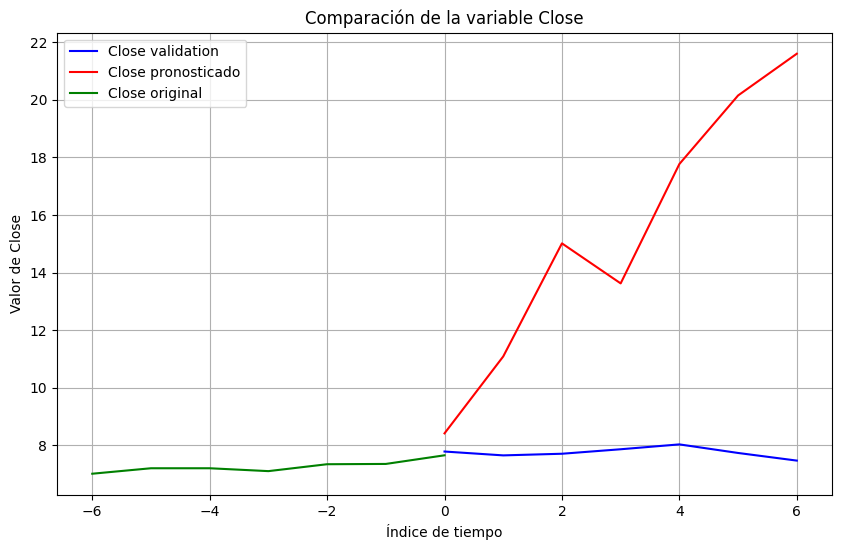

In [31]:
last_five_X_records = prophett_dataset.tail(7)
last_five_X_records.index = range(-6, 1)

last_X_forecasts = forecast['yhat7'].tail(7)
last_X_forecasts.index = range(0, 7)

plt.figure(figsize=(10, 6))
plt.plot(validation['Close'].head(7), label='Close validation', color='blue')
plt.plot(last_X_forecasts, label='Close pronosticado', color='red')
plt.plot(last_five_X_records['Close'], label='Close original', color='green')
plt.title('Comparación de la variable Close')
plt.xlabel('Índice de tiempo')
plt.ylabel('Valor de Close')
plt.legend()
plt.grid(True)
plt.show()

Veo que overfittea en train, pero no generaliza bien.. No encontre de momento, formas de optimizar esto sin caer en underfitting

### LightGBM:

    1- Single-Step Forecasting
    2- Multi-Step Forecasting (Recursive Strategy) <= va retroalimentando el dataset
    3- Multi-Step Forecasting (Direct Strategy) <= usa siempre el ultimo data
    4- Multi-Step Forecasting (DirRec Strategy) <= arma N modelos y cada uno se entrena para predecir M dias adelante

Opcion 5: Idea propia, armar un ensamble de  GBMs y que cada uno se encargue de predecir una variable para el dia siguiente ?

### Auto ML